# **Submission Akhir Machine Learning Terapan - Movies Recommendation**

**By Edwin Mahendra**<br>
Connect with me on
[Instagram](https://www.instagram.com/edwinmahendra_) or
[GitHub](https://github.com/edwinmahendra) or
[LinkedIn](https://www.linkedin.com/in/edwin-mahendra-a2944821b/)
<hr>

Pada **proyek akhir course Dicoding - Machine Learning Terapan** ini, dibuat model untuk sistem rekomendasi *movies* dengan menggunakan **Content-based Filtering** dengan beberapa teknik, termasuk **algoritma vektorisasi TF-IDF** dan **salah satu *pre-trained model* SBERT** dari sinopsis film. Dalam upaya meningkatkan akurasi rekomendasi, **fitur tambahan seperti genre, kata kunci, top 5 cast, dan sutradara juga digabungkan ke dalam model**. Dengan pendekatan ini, sistem dapat memberikan rekomendasi yang lebih relevan dan spesifik, mencerminkan preferensi dan selera pengguna dengan lebih baik.

## **Import Library**

Bagian kode ini digunakan untuk mengimport semua library dan modul yang diperlukan untuk mengerjakan proyek.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval
import operator

from sklearn.metrics.pairwise import cosine_similarity

!pip install sentence_transformers

from sentence_transformers import SentenceTransformer

!pip install scikit-surprise

from surprise import Reader, Dataset
from surprise.model_selection import cross_validate

%matplotlib inline
import warnings; warnings.simplefilter('ignore')

import json
import zipfile
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path

print()
print('Setup library successful')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 87.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 85.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 32.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 93.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 81.1 MB/s eta 0:00:00
  Created wheel for sentence_transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125926 sha256=1bd5f40adc742fab0270f26d677077a947f3cece46571fb9d97e8851e9177d34
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence_transformers
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 51.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surp

## **Download Dataset**

Untuk melanjutkan proyek Machine Learning ini, diperlukan dataset yang akan digunakan sebagai bahan atau data dalam prosesnya. Dataset yang dipilih adalah The Movies Dataset, yang dapat diunduh melalui Kaggle menggunakan tautan berikut:

**The Movies Dataset:** https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset

In [2]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

api_token = {"username":"edwinmahendraa","key":"bac357079ce9ef39f03d76d95ad91ce4"}

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

In [3]:
! kaggle datasets download rounakbanik/the-movies-dataset

print('Dataset was successfully downloaded')

 99% 225M/228M [00:10<00:00, 24.2MB/s]
100% 228M/228M [00:10<00:00, 22.0MB/s]
Dataset was successfully downloaded


## **Dataset Extraction**

Kode berikut dijalankan untuk melakukan ekstraksi pada file data (.zip) yang telah terunduh sebelumnya dari Kaggle

In [4]:
import zipfile

dataset = 'the-movies-dataset.zip'
zip_ref = zipfile.ZipFile(dataset, 'r')
zip_ref.extractall()
zip_ref.close()

print('Extraction was successful')

Extraction was successful


## **Load Dataset**

Dengan mengambil data dari file CSV, kita mendapatkan satu DataFrame, yaitu `movies_data`, yang berisi informasi terkait detail film dari dataset tersebut.

DataFrames ini dapat digunakan untuk analisis data lebih lanjut, pemrosesan data, atau membangun model machine learning berdasarkan dataset film ini.

In [5]:
movies_data = pd.read_csv('movies_metadata.csv')

In [6]:
movies_data.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


## **Dataset Exploration and Preparation**

Dataset ini terdiri dari 45.466 baris dan 24 kolom. Terdapat kolom-kolom dengan tipe data float64 dan object. Beberapa kolom memiliki jumlah entri non-null yang berbeda-beda, menandakan adanya **missing values** dalam dataset.

In [7]:
movies_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45466 non-null  object 
 1   belongs_to_collection  4494 non-null   object 
 2   budget                 45466 non-null  object 
 3   genres                 45466 non-null  object 
 4   homepage               7782 non-null   object 
 5   id                     45466 non-null  object 
 6   imdb_id                45449 non-null  object 
 7   original_language      45455 non-null  object 
 8   original_title         45466 non-null  object 
 9   overview               44512 non-null  object 
 10  popularity             45461 non-null  object 
 11  poster_path            45080 non-null  object 
 12  production_companies   45463 non-null  object 
 13  production_countries   45463 non-null  object 
 14  release_date           45379 non-null  object 
 15  re

In [8]:
movies_data.isnull().sum()

adult                        0
belongs_to_collection    40972
budget                       0
genres                       0
homepage                 37684
id                           0
imdb_id                     17
original_language           11
original_title               0
overview                   954
popularity                   5
poster_path                386
production_companies         3
production_countries         3
release_date                87
revenue                      6
runtime                    263
spoken_languages             6
status                      87
tagline                  25054
title                        6
video                        6
vote_average                 6
vote_count                   6
dtype: int64

Dari data dan informasi yang diberikan pada bagian kode sebelumnya, ternyata terdapat beberapa kolom yang datanya kosong atau hilang atau tidak lengkap. Oleh karena itu pada kode dibawah ini terdapat beberapa hal yang bisa dilakukan untuk menangani hal ini sebelum pembuatan model

### **Penghapusan Kolom**

Berdasarkan data dan deskripsinya, kita bisa mengabaikan kolom berikut karena tidak memberikan nilai "tambah" untuk keperluan analisis dan pengembangan model lebih lanjut.

Berikut adalah daftar kolom yang dihapus:

+ adult
+ homepage
+ imbd_id
+ poster_path
+ video




In [9]:
movies_data.drop(['adult', 'homepage', 'imdb_id', 'poster_path', 'video'] , axis=1, inplace=True)

### **Replace Column Values or Add Some Feature**

Kode ini akan menghapus semua baris dalam movies_data di mana kolom vote_average memiliki **nilai NaN**.

In [10]:
movies_data.drop(movies_data[movies_data['vote_average'].isna() == True].index, axis=0, inplace=True)

In [11]:
movies_data.shape

(45460, 19)

Kode ini mengubah kolom 'belongs_to_collection' dalam DataFrame menjadi nilai biner. Fungsi notna() akan menghasilkan True untuk setiap entri yang bukan NaN, dan False untuk entri yang NaN. astype('int') lalu mengubah nilai boolean ini menjadi 1 untuk True dan 0 untuk False.

In [12]:
movies_data['belongs_to_collection'] = movies_data['belongs_to_collection'].notna().astype('int')

Kode ini menerapkan fungsi literal_eval pada setiap entri dalam kolom 'genres' dan mengubah string representasi list menjadi list sebenarnya. Setelah itu, fungsi lambda menerapkan list comprehension untuk setiap list (jika entri adalah list) untuk mengambil nilai dari kunci 'name'.

In [13]:
columns_to_process = ['genres', 'production_companies', 'production_countries', 'spoken_languages']

for column in columns_to_process:
    movies_data[column] = movies_data[column].apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

Kode ini mengubah kolom 'release_date' menjadi tipe data datetime menggunakan fungsi **pd.to_datetime**. Opsi errors='coerce' berarti bahwa jika ada kesalahan dalam konversi, nilai tersebut akan menjadi NaT (Not a Time). Kemudian, **.dt.year** digunakan untuk **mengambil tahun dari tanggal tersebut**.

In [14]:
movies_data['year'] = pd.to_datetime(movies_data['release_date'], errors='coerce').dt.year.convert_dtypes()

Kode ini pertama-tama memfilter DataFrame untuk hanya **menyertakan** baris di mana **status film** adalah **'Released'**. Kemudian, kode ini **menghapus kolom 'status'** dari DataFrame.

In [15]:
movies_data = movies_data[movies_data['status'] == 'Released']
del movies_data['status']

In [16]:
# List of string columns that you want to replace NaN with ''
str_cols = ['original_language', 'overview', 'tagline', 'title']

# Replace NaN with '' in string columns
for col in str_cols:
    movies_data[col] = movies_data[col].fillna('')

# List of numeric columns that you want to replace NaN with 0
num_cols = ['runtime', 'year', 'release_date']

# Replace NaN with 0 in numeric columns
for col in num_cols:
    movies_data[col] = movies_data[col].fillna(0)

Melakukan pengecekan kembali untuk 5 data teratas pada DataFrame movies_data

In [17]:
movies_data.head()

,belongs_to_collection,budget,genres,id,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,tagline,title,vote_average,vote_count,year
0,1,30000000,"[Animation, Comedy, Family]",862,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,[Pixar Animation Studios],[United States of America],1995-10-30,373554033.0,81.0,[English],,Toy Story,7.7,5415.0,1995
1,0,65000000,"[Adventure, Fantasy, Family]",8844,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,"[TriStar Pictures, Teitler Film, Interscope Co...",[United States of America],1995-12-15,262797249.0,104.0,"[English, Français]",Roll the dice and unleash the excitement!,Jumanji,6.9,2413.0,1995
2,1,0,"[Romance, Comedy]",15602,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,"[Warner Bros., Lancaster Gate]",[United States of America],1995-12-22,0.0,101.0,[English],Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,6.5,92.0,1995
3,0,16000000,"[Comedy, Drama, Romance]",31357,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,[Twentieth Century Fox Film Corporation],[United States of America],1995-12-22,81452156.0,127.0,[English],Friends are the people who let you be yourself...,Waiting to Exhale,6.1,34.0,1995
4,1,0,[Comedy],11862,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,"[Sandollar Productions, Touchstone Pictures]",[United States of America],1995-02-10,76578911.0,106.0,[English],Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,5.7,173.0,1995


Jalankan kembali kode berikut untuk menghitung jumlah *missing value* pada setiap kolom pada DataFrame

In [18]:
movies_data.isnull().sum()

belongs_to_collection    0
budget                   0
genres                   0
id                       0
original_language        0
original_title           0
overview                 0
popularity               0
production_companies     0
production_countries     0
release_date             0
revenue                  0
runtime                  0
spoken_languages         0
tagline                  0
title                    0
vote_average             0
vote_count               0
year                     0
dtype: int64

## **Base Recommendation System**



Fungsi **get_genre_filtered_data** digunakan untuk mengambil data film yang memiliki genre tertentu. Jika parameter genre diberikan, fungsi ini akan memfilter data berdasarkan genre yang diinginkan.

In [19]:
def get_genre_filtered_data(data, genre):
    if genre:
        data['is_genre'] = data['genres'].apply(lambda x: genre in x)
        data = data[data['is_genre']]
    return data

Fungsi **calculate_vote_quantile** digunakan untuk menghitung suara (vote) minimum yang harus dimiliki suatu film agar dianggap populer. Parameter **percentile** menentukan persentase suara minimum yang ingin dihitung.

In [20]:
def calculate_vote_quantile(data, percentile):
    return round(data['vote_count'].quantile(percentile))

Fungsi **calculate_vote_average** digunakan untuk menghitung nilai rata-rata suara (vote) dari data film.

In [21]:
def calculate_vote_average(data):
    return round(data['vote_average'].mean(), 1)

Fungsi **compute_weighted_rating** digunakan untuk menghitung nilai rating terbobot suatu film berdasarkan suara (vote) film, nilai rata-rata suara, dan faktor bobot tertentu.

Keterangan variabel:

+ **v (vote_count):** Jumlah orang yang memberikan suara pada film tersebut.
+ **m (Minimum number of ratings):** Jumlah minimum suara yang diperlukan agar film tersebut dapat terdaftar dalam daftar peringkat.
+ **R (vote_average):** Nilai rata-rata dari suara yang diberikan pada film tersebut. Rata-rata ini mencerminkan penilaian keseluruhan film oleh para penonton.
+ **C (Mean of ratings):** Rata-rata suara dari seluruh dataset film. Nilai ini digunakan sebagai titik acuan untuk membandingkan rating film secara relatif.


In [22]:
def compute_weighted_rating(data, vote_quantile, vote_average):
    v = data['vote_count']
    R = data['vote_average']
    m = vote_quantile
    C = vote_average
    return round((v*R/(v+m)) + (m*C/(m+v)),1)

Fungsi berikut adalah **fungsi utama** yang menggabungkan langkah-langkah sebelumnya untuk merekomendasikan film. Fungsi ini melakukan filtrasi data berdasarkan genre, menghitung suara minimum dan nilai rata-rata suara, serta menghitung nilai rating terbobot untuk setiap film. Hasilnya adalah daftar **film yang memenuhi kriteria dan diurutkan berdasarkan bobot rating dan tahun**. Fungsi ini mengembalikan **sejumlah film yang direkomendasikan**.

In [23]:
def simple_movie_recommender(data, num_movies=10, genre='', percentile=0.95):
    data = get_genre_filtered_data(data, genre)
    vote_quantile = calculate_vote_quantile(data, percentile)
    vote_average = calculate_vote_average(data)

    qualified_movies = data[data['vote_count'] >= vote_quantile][['title', 'year', 'vote_count', 'vote_average', 'popularity', 'genres']]
    qualified_movies['weighted_rating'] = qualified_movies.apply(lambda row: compute_weighted_rating(row, vote_quantile, vote_average), axis=1)
    qualified_movies.sort_values(['weighted_rating', 'year'], ascending=[False, False], inplace=True)

    return qualified_movies.head(num_movies)

top_movies = simple_movie_recommender(movies_data)

In [24]:
top_movies

,title,year,vote_count,vote_average,popularity,genres,weighted_rating
314,The Shawshank Redemption,1994,8358.0,8.5,51.645403,"[Drama, Crime]",8.4
834,The Godfather,1972,6024.0,8.5,41.109264,"[Drama, Crime]",8.3
12481,The Dark Knight,2008,12269.0,8.3,123.167259,"[Drama, Action, Crime, Thriller]",8.2
2843,Fight Club,1999,9678.0,8.3,63.869599,[Drama],8.2
292,Pulp Fiction,1994,8670.0,8.3,140.950236,"[Thriller, Crime]",8.2
23673,Whiplash,2014,4376.0,8.3,64.29999,[Drama],8.1
351,Forrest Gump,1994,8147.0,8.2,48.307194,"[Comedy, Drama, Romance]",8.1
522,Schindler's List,1993,4436.0,8.3,41.725123,"[Drama, History, War]",8.1
22879,Interstellar,2014,11187.0,8.1,32.213481,"[Adventure, Drama, Science Fiction]",8.0
18465,The Intouchables,2011,5410.0,8.2,16.086919,"[Drama, Comedy]",8.0


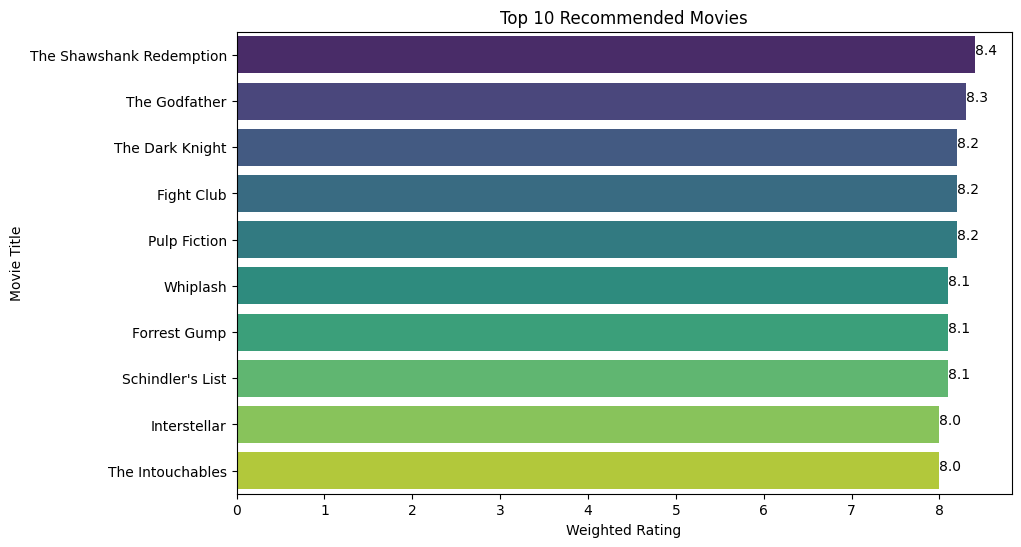

In [25]:
# Call the simple_movie_recommender function to get top 10 movies
top_movies = simple_movie_recommender(movies_data, num_movies=10)

# Plotting
plt.figure(figsize=(10,6))
sns.barplot(y=top_movies['title'], x=top_movies['weighted_rating'], palette='viridis')
plt.title('Top 10 Recommended Movies')
plt.xlabel('Weighted Rating')
plt.ylabel('Movie Title')

# Add ratings on the bars
for index, value in enumerate(top_movies['weighted_rating']):
    plt.text(value, index, str(value))

plt.show()

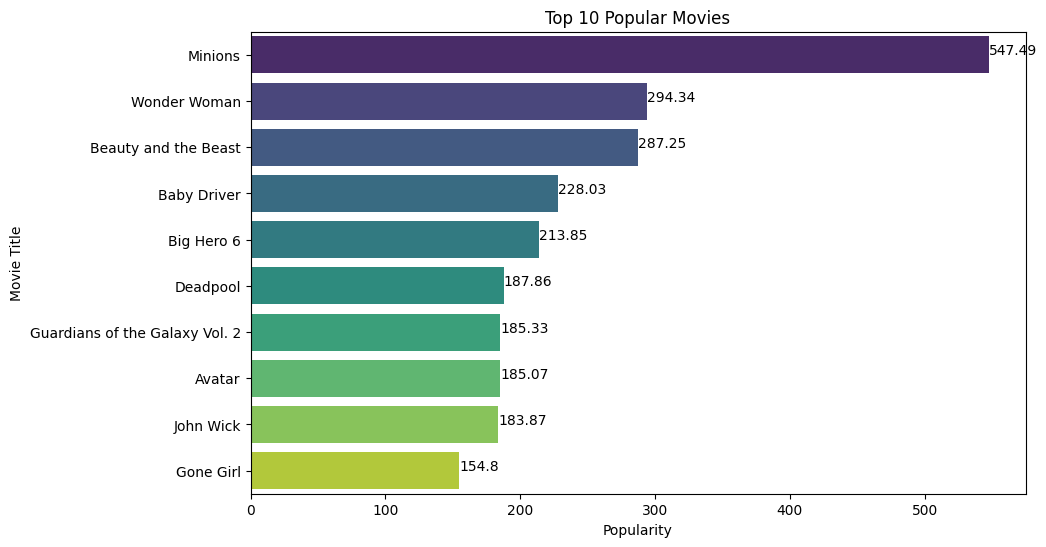

In [26]:
# Convert the popularity column to numeric data type
movies_data['popularity'] = pd.to_numeric(movies_data['popularity'], errors='coerce')

# Sort the DataFrame by the popularity column in descending order
sorted_df = movies_data.sort_values(by='popularity', ascending=False)

# Display the top 10 movies with the highest popularity
top_10_popular_movies = sorted_df.head(10)

# Create a bar graph for the top 10 popular movies
plt.figure(figsize=(10,6))
sns.barplot(y=top_10_popular_movies['title'], x=top_10_popular_movies['popularity'], palette='viridis')
plt.title('Top 10 Popular Movies')
plt.xlabel('Popularity')
plt.ylabel('Movie Title')

# Add popularity scores on the bars
for index, value in enumerate(top_10_popular_movies['popularity']):
    plt.text(value, index, str(round(value, 2)))

plt.show()

Sekarang kita mencoba untuk melakukan rekomendasi berdasarkan bobot rating dengan **genre Horror**

In [27]:
top_horror_movies = simple_movie_recommender(movies_data, genre='Horror')
top_horror_movies

,title,year,vote_count,vote_average,popularity,genres,weighted_rating
1213,The Shining,1980,3890.0,8.1,19.611589,"[Horror, Thriller]",7.8
1176,Psycho,1960,2405.0,8.3,36.826309,"[Drama, Horror, Thriller]",7.8
1171,Alien,1979,4564.0,7.9,23.377420,"[Horror, Action, Thriller, Science Fiction]",7.6
1158,Aliens,1986,3282.0,7.7,21.761179,"[Horror, Action, Thriller, Science Fiction]",7.4
2175,The Thing,1982,1629.0,7.8,16.831250,"[Horror, Mystery, Science Fiction]",7.2
1338,Jaws,1975,2628.0,7.5,19.726114,"[Horror, Thriller, Adventure]",7.2
21276,The Conjuring,2013,3169.0,7.4,14.901690,"[Horror, Thriller]",7.1
8147,Shaun of the Dead,2004,2479.0,7.5,14.902948,"[Horror, Comedy]",7.1
1888,The Exorcist,1973,2046.0,7.5,12.137595,"[Drama, Horror, Thriller]",7.1
14236,Zombieland,2009,3655.0,7.2,11.063029,"[Comedy, Horror]",7.0


Sekarang kita mencoba untuk melakukan rekomendasi berdasarkan bobot rating dengan **genre Action**

In [28]:
top_action_movies = simple_movie_recommender(movies_data, genre='Action')
top_action_movies

,title,year,vote_count,vote_average,popularity,genres,weighted_rating
12481,The Dark Knight,2008,12269.0,8.3,123.167259,"[Drama, Action, Crime, Thriller]",8.0
15480,Inception,2010,14075.0,8.1,29.108149,"[Action, Thriller, Science Fiction, Mystery, A...",7.9
7000,The Lord of the Rings: The Return of the King,2003,8226.0,8.1,29.324358,"[Adventure, Fantasy, Action]",7.7
4863,The Lord of the Rings: The Fellowship of the Ring,2001,8892.0,8.0,32.070725,"[Adventure, Fantasy, Action]",7.7
1154,The Empire Strikes Back,1980,5998.0,8.2,19.470959,"[Adventure, Action, Science Fiction]",7.7
256,Star Wars,1977,6778.0,8.1,42.149697,"[Adventure, Action, Science Fiction]",7.7
23753,Guardians of the Galaxy,2014,10014.0,7.9,53.291601,"[Action, Science Fiction, Adventure]",7.6
5814,The Lord of the Rings: The Two Towers,2002,7641.0,8.0,29.423537,"[Adventure, Fantasy, Action]",7.6
2458,The Matrix,1999,9079.0,7.9,33.366332,"[Action, Science Fiction]",7.6
13605,Inglourious Basterds,2009,6598.0,7.9,16.895640,"[Drama, Action, Thriller, War]",7.5


Rekomendasi film sederhana yang telah dibangun pada bagian sebelumnya memiliki daya tarik yang luas, tetapi mengalami **kelemahan** karena **tidak menawarkan solusi yang dipersonalisasi untuk pengguna**. **Rekomendasi** yang diberikan **sama untuk semua orang**, tanpa mempertimbangkan selera pribadi pengguna. Oleh karena itu, untuk mempersonalisasi rekomendasi, kita dapat menggunakan masukan yang relevan seperti konten film, genre, dll. Hal ini akan memberikan saran yang lebih baik bagi pengguna yang diberikan. Sistem seperti ini disebut sebagai Content Based Recommender yang akan dibuat pada bagian kode berikutnya.

Dengan menggabungkan preferensi pengguna dan konten film, Content-Based Recommender menawarkan rekomendasi yang lebih dipersonalisasi dan sesuai dengan preferensi pengguna. Sistem ini mempertimbangkan selera dan minat khusus pengguna, menghasilkan pengalaman rekomendasi film yang lebih khusus dan memuaskan.

## **Content-based Filtering**

Dalam proyek ini, teknik Content-Based Filtering digunakan untuk memberikan rekomendasi film berdasarkan kesamaan konten atau karakteristik film itu sendiri. Proses ini melibatkan beberapa metode penting. Sebagai titik awal, **algoritma TF-IDF Vectorizer** digunakan untuk merubah teks dari sinopsis film menjadi vektor numerik. Vektor ini kemudian digunakan untuk mengukur kesamaan antara film, yang memungkinkan kita untuk membuat rekomendasi.

Setelah itu, **untuk meningkatkan efisiensi sistem rekomendasi**, **SBERT**, atau Sentence-BERT, digunakan sebagai model yang telah dilatih sebelumnya. Tujuan penggunaan SBERT adalah untuk **meningkatkan kualitas vektorisasi dan berpotensi memberikan skor similaritas yang lebih tinggi antara film.**

Terakhir, untuk lebih mempersonalisasi sistem rekomendasi dan **membuat rekomendasi yang lebih akurat**, beberapa **fitur tambahan** seperti **genre**, **keywords**, **top 5 cast**, dan **director digabungkan**. Dengan memasukkan fitur-fitur ini ke dalam model, rekomendasi yang lebih relevan dan spesifik dapat disediakan kepada pengguna, yang mencerminkan preferensi dan selera mereka secara lebih baik.

### **Content-based Filtering with TF-IDF Vectorizer**

Fungsi ini digunakan untuk menghitung nilai kuantil dari jumlah vote (vote_count). Dalam kasus ini, kita mengambil **nilai kuantil 95%** dan menggunakannya sebagai **batas minimal vote_count** yang akan kita gunakan dalam data film. Jadi, kita hanya akan mengambil film-film yang jumlah vote-nya berada di kuantil 95% atau lebih.

Hal ini dilakukan karena mempengaruhi waktu pemrosesan sehingga waktu pemrosesan akan lebih cepat



In [29]:
# Function to calculate vote quantile
def calculate_vote_quantile(data, percentile):
    return round(data['vote_count'].quantile(percentile))

m = calculate_vote_quantile(movies_data, 0.95)
C = round(movies_data['vote_average'].mean(), 1)

movies_data = movies_data[(movies_data['vote_count'] >= m)][['id', 'title', 'year', 'vote_count', 'vote_average', 'popularity', 'genres', 'overview']]

Di sini kita menggunakan **TfidfVectorizer** dari library sklearn untuk **menghitung skor TF-IDF dari data teks** dalam kolom overview. TF-IDF adalah metode untuk mengubah teks menjadi angka yang dapat digunakan oleh algoritma machine learning. Lalu kita juga akan menghilangkan *stop words* yang ada di dalam bahasa Inggris

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(stop_words='english')

movies_data['overview'] = movies_data['overview'].fillna('')

tfidf.fit(movies_data['overview'])

tfidf.get_feature_names_out()

array(['00', '000', '007', ..., 'zuckerberg', 'æon', 'émigré'],
      dtype=object)

Di sini kita melakukan transformasi data dari kolom overview menjadi matriks TF-IDF menggunakan fitur yang telah dipelajari oleh TfidfVectorizer.

In [31]:
tfidf_matrix = tfidf.fit_transform(movies_data['overview'])

tfidf_matrix.shape

(2255, 13528)

Menampilkan matriks TF-IDF dalam bentuk dense (mengubah matriks sparse menjadi matriks biasa).

In [32]:
tfidf_matrix.todense()

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

Langkah ini melibatkan pembuatan DataFrame pandas dari matriks fitur TF-IDF. Baris dalam DataFrame ini sesuai dengan judul film dan kolom sesuai dengan fitur yang dihasilkan oleh TfidfVectorizer.

In [33]:
pd.DataFrame(
    tfidf_matrix.todense(),
    columns=tfidf.get_feature_names_out(),
    index=movies_data.title
).sample(22, axis=1).sample(100, axis=0)

,vorhees,nunnery,80,scheming,cohorts,stick,insurgents,tailspin,teri,histories,...,social,competitor,possibly,tragedies,pre,demon,hippo,virginian,ball,radar
title,,,,,,,,,,,,,,,,,,,,,
Fool's Gold,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Milk,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Amy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Eastern Promises,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
The Ugly Truth,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Beauty and the Beast,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Ex Machina,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Jack the Giant Slayer,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Dengan menggunakan fungsi cosine_similarity dari library sklearn, dihitunglah similaritas kosinus antara fitur setiap pasangan film. Hasilnya adalah matriks simetri dimana elemen pada baris i dan kolom j adalah similaritas kosinus antara fitur film i dan j.

In [34]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim = cosine_similarity(tfidf_matrix)
cosine_sim

array([[1.        , 0.01884302, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.01884302, 1.        , 0.05115235, ..., 0.00623471, 0.        ,
        0.01134885],
       [0.        , 0.05115235, 1.        , ..., 0.        , 0.        ,
        0.01562965],
       ...,
       [0.        , 0.00623471, 0.        , ..., 1.        , 0.01572782,
        0.02636232],
       [0.        , 0.        , 0.        , ..., 0.01572782, 1.        ,
        0.        ],
       [0.        , 0.01134885, 0.01562965, ..., 0.02636232, 0.        ,
        1.        ]])

Dalam langkah ini, dibuat DataFrame dari cosine similarity matrix. Baris dan kolom dalam DataFrame ini sesuai dengan judul film.

In [35]:
indices = pd.Series(movies_data.index, index=movies_data['title']).drop_duplicates()

In [36]:
cosine_sim_df = pd.DataFrame(cosine_sim, index=movies_data['title'], columns=movies_data['title'])
print('Shape:', cosine_sim_df.shape)

Shape: (2255, 2255)


#### **1 - Movies Recommendation Function**

Fungsi ini dibuat untuk memberikan rekomendasi film berdasarkan judul film yang diberikan. Fungsi ini menggunakan similaritas kosinus antara film-film untuk menghasilkan rekomendasi. Fungsi ini mengembalikan DataFrame berisi judul film yang paling mirip, genre, tahun, dan jumlah *similarity score*.

In [37]:
def movies_recommendations(movie, similarity_data=cosine_sim_df, items=movies_data[['title','genres', 'year']], k=10):
    # Get data using argpartition for indirect partitioning along the given axis
    # Dataframe is changed to numpy
    # Range(start, stop, step)
    index = similarity_data.loc[:, movie].to_numpy().argpartition(range(-1, -k, -1))

    # Get the data with the highest similarity from the existing index
    closest = similarity_data.columns[index[-1:-(k+2):-1]]

    # Drop the title so the film being searched doesn't appear in the recommendation list
    closest = closest.drop(movie, errors='ignore')

    # Getting similarity scores
    similarity_scores = similarity_data.loc[closest, movie]

    # Create dataframe from closest movies
    closest_movies = pd.DataFrame(closest).merge(items, on='title')

    # Add similarity scores to the dataframe
    closest_movies['similarity_score'] = (similarity_scores.values * 100).round(2)

    return closest_movies

In [38]:
movies_recommendations('The Dark Knight')

,title,genres,year,similarity_score
0,The Dark Knight Rises,"[Action, Crime, Drama, Thriller]",2012,28.11
1,Batman Returns,"[Action, Fantasy]",1992,21.41
2,Batman: Under the Red Hood,"[Action, Animation]",2010,20.82
3,Batman Forever,"[Action, Crime, Fantasy]",1995,19.76
4,Batman,"[Fantasy, Action]",1989,16.33
5,Batman: The Killing Joke,"[Action, Animation, Crime, Drama]",2016,15.97
6,Batman Begins,"[Action, Crime, Drama]",2005,14.36
7,The Lego Batman Movie,"[Action, Animation, Comedy, Family, Fantasy]",2017,14.35
8,JFK,"[Drama, Thriller, History]",1991,13.74
9,Law Abiding Citizen,"[Drama, Crime, Thriller]",2009,10.35


### **Content-based Filtering with SBERT**


Untuk meningkatkan kualitas similarity score dalam sistem rekomendasi sebelumnya, kita **beralih menggunakan SBERT** untuk mengubah **konten film menjadi vektor**. Sebelumnya, kita telah menggunakan **metode TF-IDF** untuk vektorisasi, namun **hasilnya kurang memuaskan**. Oleh karena itu, kita menggunakan model SBERT '**all-mpnet-base-v2**' yang **telah terbukti memberikan performa terbaik** berdasarkan data dan dokumentasi yang ada di https://www.sbert.net/docs/pretrained_models.html. Dengan menggunakan SBERT, diharapkan kita dapat menghasilkan similarity score yang lebih efektif dan akurat dalam sistem rekomendasi film.

In [39]:
df1 = movies_data[(movies_data['vote_count'] >= m)][['id', 'title', 'year', 'vote_count', 'vote_average', 'popularity', 'genres', 'overview']]

df1.shape

(2255, 8)

In [40]:
df1.head()

,id,title,year,vote_count,vote_average,popularity,genres,overview
0,862,Toy Story,1995,5415.0,7.7,21.946943,"[Animation, Comedy, Family]","Led by Woody, Andy's toys live happily in his ..."
1,8844,Jumanji,1995,2413.0,6.9,17.015539,"[Adventure, Fantasy, Family]",When siblings Judy and Peter discover an encha...
5,949,Heat,1995,1886.0,7.7,17.924927,"[Action, Crime, Drama, Thriller]","Obsessive master thief, Neil McCauley leads a ..."
9,710,GoldenEye,1995,1194.0,6.6,14.686036,"[Adventure, Action, Thriller]",James Bond must unmask the mysterious head of ...
15,524,Casino,1995,1343.0,7.8,10.137389,"[Drama, Crime]",The life of the gambling paradise – Las Vegas ...


Ini adalah bagian di mana kita mengambil data teks (konten *movies*) dan **mentransformasikannya menjadi vektor** yang dapat dianalisis. **'all-mpnet-base-v2'** adalah **model pretrained dari library SentenceTransformer**, yang digunakan untuk menghasilkan embeddings dari teks.

In [41]:
text_data = np.array(df1['overview'])
model = SentenceTransformer('all-mpnet-base-v2')
embeddings = model.encode(text_data, show_progress_bar=True)

Batches:   0%|          | 0/71 [00:00<?, ?it/s]

Kode berikut ini digunakan untuk mendapatkan fitur dari kalimat yang digunakan oleh model.

In [42]:
model.get_sentence_features

<bound method SentenceTransformer.get_sentence_features of SentenceTransformer(
  (0): Transformer({'max_seq_length': 384, 'do_lower_case': False}) with Transformer model: MPNetModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (2): Normalize()
)>

Di bagian ini, kita **menghitung kesamaan cosine** antara setiap pasangan film berdasarkan embeddings dari sinopsis mereka.

In [43]:
cos_sim_data = pd.DataFrame(cosine_similarity(embeddings))

Mengatur ulang indeks DataFrame dan mempersiapkan data yang akan digunakan untuk sistem rekomendasi, serta membuat map terbalik dari indeks dan judul film.

In [44]:
df = df1.reset_index()
data = df[['title','genres','year']]

#### **2 - Movies Recommendation Function**

Ini adalah **fungsi utama** yang digunakan untuk **mendapatkan rekomendasi film** **berdasarkan judul film** yang diberikan. Fungsi ini mencari N film yang paling mirip dengan film yang diberikan berdasarkan sinopsisnya.

Pertama, kita membangun pemetaan balik dari indeks dan judul film. Kemudian kita mendefinisikan fungsi get_recommendations, yang akan mengambil judul film dan memberikan rekomendasi film lain yang paling mirip. Film-film yang direkomendasikan diurutkan berdasarkan skor kesamaan, dan skor kesamaan ini dihitung berdasarkan cosine similarity antara vektor dari film yang dicari dan film-film lainnya. Skor kesamaan ini kemudian ditambahkan ke data output dan diubah menjadi persen.

In [45]:
# Construct a reverse map of indices and movie titles
indices = pd.Series(range(df.shape[0]), index=df['title']).drop_duplicates()

def get_recommendations(title, N = 10):
    idx = indices[title]
    sim_scores = list(enumerate(cos_sim_data[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:N+1]
    movie_indices = [i[0] for i in sim_scores]
    sim_scores = pd.DataFrame(sim_scores, columns = ['index', 'similarity_score'])
    final_data = data.iloc[movie_indices]
    final_data = final_data.merge(sim_scores, left_index = True, right_on ='index')
    final_data['similarity_score'] = round(final_data['similarity_score']*100,2)
    del final_data['index']
    return final_data

In [46]:
get_recommendations('The Dark Knight')

,title,genres,year,similarity_score
0,The Dark Knight Rises,"[Action, Crime, Drama, Thriller]",2012,82.82
1,Batman,"[Fantasy, Action]",1989,81.04
2,Batman Begins,"[Action, Crime, Drama]",2005,77.04
3,Batman v Superman: Dawn of Justice,"[Action, Adventure, Fantasy]",2016,69.59
4,Batman: Under the Red Hood,"[Action, Animation]",2010,69.37
5,Batman: The Killing Joke,"[Action, Animation, Crime, Drama]",2016,68.64
6,Batman Forever,"[Action, Crime, Fantasy]",1995,68.56
7,The Lego Batman Movie,"[Action, Animation, Comedy, Family, Fantasy]",2017,63.73
8,Batman Returns,"[Action, Fantasy]",1992,61.35
9,Batman & Robin,"[Action, Crime, Fantasy]",1997,59.37



Dari hasil analisis, sistem rekomendasi yang menggunakan **SBERT** (Sentence-BERT) **menghasilkan skor kesamaan yang lebih tinggi dibandingkan** dengan sistem yang menggunakan **TF-IDF Vectorizer**. Ini menunjukkan bahwa SBERT lebih efektif dalam mengidentifikasi kesamaan konten antara film-film.

Misalnya, untuk rekomendasi film berdasarkan film "The Dark Knight", sistem rekomendasi berbasis **SBERT berhasil menemukan film dengan genre yang serupa** seperti "The Dark Knight Rises" dan "Batman Begins" dengan **skor kesamaan lebih dari 75%**. Sementara itu, sistem berbasis TF-IDF menemukan film dengan genre yang sama tetapi dengan skor kesamaan yang lebih rendah.

### **Improvement**

Memasuki tahap akhir pengembangan sistem rekomendasi ini, kita akan **memperkaya pendekatan yang telah dipilih** dengan **menambahkan** beberapa fitur tambahan, seperti **genre, keywords, top 5 cast, dan director**. Ini bertujuan untuk memperbaiki dan **memperluas aspek-aspek yang digunakan dalam sistem rekomendasi**, sehingga dapat **memberikan hasil yang lebih akurat** dan sesuai dengan preferensi pengguna. Lalu pada analisis sebelumnya, telah diputuskan bahwa **Sentence-BERT (SBERT)** memberikan **hasil yang lebih baik** dalam mengukur tingkat kesamaan antara film. Oleh karena itu, kita akan terus menggunakan SBERT sebagai dasar pengembangan sistem rekomendasi ini.



Fungsi ini **memuat dataset** 'credits' dan 'keywords' dari file .csv dan **menghapus duplikat dalam data** tersebut. Fungsi ini menghasilkan dua DataFrame: 'credits' dan 'keywords'.

In [47]:
def load_data():
    credits = pd.read_csv('credits.csv')
    keywords = pd.read_csv('keywords.csv')

    # Removing duplicates from the data
    credits.drop_duplicates(inplace = True)
    keywords.drop_duplicates(inplace = True)

    return credits, keywords

Fungsi ini menerima tiga DataFrame (df, credits, keywords) sebagai input, dan menggabungkannya berdasarkan kolom 'id'. Fungsi ini memastikan bahwa kolom 'id' di ketiga DataFrame adalah tipe data yang sama (integer) sebelum melakukan penggabungan. DataFrame yang sudah digabungkan kemudian dikembalikan.

In [48]:
def merge_data(df, credits, keywords):
    keywords['id'] = keywords['id'].astype('int')
    credits['id'] = credits['id'].astype('int')
    df['id'] = df['id'].astype('int')

    df = df.merge(credits, on='id')
    df = df.merge(keywords, on='id')

    return df

Fungsi ini menerima DataFrame dan memproses kolom 'cast'. Fungsi ini pertama-tama menerapkan fungsi literal_eval ke kolom untuk mengevaluasi string sebagai kode python (cast terdaftar sebagai string berformat list). Kemudian, fungsi ini mengambil lima nama pemeran utama (atau seluruhnya jika kurang dari lima).

In [49]:
def process_cast(df):
    df['cast'] = df['cast'].apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
    df['cast'] = df['cast'].apply(lambda x: x[:5] if len(x) >=5 else x)

    return df

Fungsi ini menerima DataFrame dan memproses kolom 'keywords'. Mirip dengan fungsi process_cast, fungsi ini menerapkan literal_eval ke kolom dan mengubah string berformat list menjadi list python yang sebenarnya.

In [50]:
def process_keywords(df):
    df['keywords'] = df['keywords'].apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

    return df

Fungsi ini menerima list pekerjaan dalam film dan mengembalikan nama sutradara.

In [51]:
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

Fungsi ini menerima DataFrame dan memproses kolom 'director' dan 'cast'. Spasi dalam nama dihapus untuk menghindari ambigu dalam analisis berikutnya.

In [52]:
def process_others(df):
    df['director'] = df['crew'].apply(literal_eval).apply(get_director)

    df['cast'] = df['cast'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])
    df['director'] = df['director'].astype('str').apply(lambda x: str.lower(x.replace(" ", "")))

    df['director'] = df['director'].apply(lambda x: [i for i in x.split()])

    return df

Fungsi ini menerima DataFrame dan menggabungkan semua metadata yang relevan (genre, keywords, director, cast) menjadi satu string.

In [53]:
def concat_metadata(df):
    df['metadata'] = df['genres'] + df['keywords'] + df['director'] + df['cast']

    df['metadata'] = df['metadata'].apply(lambda x: ' '.join(x))

    return df

Fungsi utama yang **memanggil semua fungsi pemrosesan data** di atas dan menggabungkannya menjadi satu.

In [54]:
def main(df):
    credits, keywords = load_data()
    df = merge_data(df, credits, keywords)
    df = process_cast(df)
    df = process_keywords(df)
    df = process_others(df)
    df = concat_metadata(df)

    return df

In [55]:
df = main(df1)

In [56]:
df.head()

,id,title,year,vote_count,vote_average,popularity,genres,overview,cast,crew,keywords,director,metadata
0,862,Toy Story,1995,5415.0,7.7,21.946943,"[Animation, Comedy, Family]","Led by Woody, Andy's toys live happily in his ...","[tomhanks, timallen, donrickles, jimvarney, wa...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[jealousy, toy, boy, friendship, friends, riva...",[johnlasseter],Animation Comedy Family jealousy toy boy frien...
1,8844,Jumanji,1995,2413.0,6.9,17.015539,"[Adventure, Fantasy, Family]",When siblings Judy and Peter discover an encha...,"[robinwilliams, jonathanhyde, kirstendunst, br...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[board game, disappearance, based on children'...",[joejohnston],Adventure Fantasy Family board game disappeara...
2,949,Heat,1995,1886.0,7.7,17.924927,"[Action, Crime, Drama, Thriller]","Obsessive master thief, Neil McCauley leads a ...","[alpacino, robertdeniro, valkilmer, jonvoight,...","[{'credit_id': '52fe4292c3a36847f802916d', 'de...","[robbery, detective, bank, obsession, chase, s...",[michaelmann],Action Crime Drama Thriller robbery detective ...
3,710,GoldenEye,1995,1194.0,6.6,14.686036,"[Adventure, Action, Thriller]",James Bond must unmask the mysterious head of ...,"[piercebrosnan, seanbean, izabellascorupco, fa...","[{'credit_id': '52fe426ec3a36847f801e14b', 'de...","[cuba, falsely accused, secret identity, compu...",[martincampbell],Adventure Action Thriller cuba falsely accused...
4,524,Casino,1995,1343.0,7.8,10.137389,"[Drama, Crime]",The life of the gambling paradise – Las Vegas ...,"[robertdeniro, sharonstone, joepesci, jameswoo...","[{'credit_id': '52fe424dc3a36847f80139cd', 'de...","[poker, drug abuse, 1970s, overdose, illegal p...",[martinscorsese],Drama Crime poker drug abuse 1970s overdose il...


In [57]:
meta_data = np.array(df['metadata'])
model = SentenceTransformer('all-mpnet-base-v2') # All-round model tuned for many use-cases. Trained on a large and diverse dataset of over 1 billion training pairs.
embeddings = model.encode(meta_data, show_progress_bar=True)

Batches:   0%|          | 0/71 [00:00<?, ?it/s]

In [58]:
cos_sim_data = pd.DataFrame(cosine_similarity(embeddings))

In [59]:
df = df.reset_index()
data = df[['title','genres','year']]
indices = pd.Series(df.index, index=df['title'])

Fungsi ini menghitung skor kesamaan antara judul film yang diberikan dan semua film lainnya dalam dataset.

In [60]:
def calculate_similarity_scores(title, cos_sim_data):
    idx = indices[title]
    sim_scores = list(enumerate(cos_sim_data[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    return sim_scores

Fungsi ini mengambil skor kesamaan dan mengembalikan N film teratas yang paling serupa dengan film yang diberikan.

In [61]:
def get_movie_data(sim_scores, N):
    movie_indices = [i[0] for i in sim_scores]
    sim_scores_df = pd.DataFrame(sim_scores, columns = ['index', 'similarity_score'])

    movies = df.iloc[movie_indices][['title', 'genres', 'vote_count', 'vote_average', 'year']]
    final_data = movies.merge(sim_scores_df, left_index = True, right_on ='index')
    final_data['similarity_score'] = round(final_data['similarity_score']*100,2)
    del final_data['index']

    return final_data

Fungsi ini menghitung rating tertimbang berdasarkan formula IMDb.

In [62]:
def calculate_weighted_rating(x, m, C):
    v = x['vote_count']
    R = x['vote_average']
    return round((v*R/(v+m)) + (m*C/(m+v)),1)

Fungsi utama yang menerima judul film dan mengembalikan N rekomendasi film teratas berdasarkan kesamaan metadata dan rating tertimbang.

In [63]:
def get_recommendations_2(title, N=10):
    sim_scores = calculate_similarity_scores(title, cos_sim_data)
    sim_scores = sim_scores[1:N+1]

    final_data = get_movie_data(sim_scores, N)

    m = round(df['vote_count'].quantile(0.95))
    C = round(df['vote_average'].mean(), 1)

    final_data['weighted_rating'] = final_data.apply(calculate_weighted_rating, args=(m,C), axis=1)
    final_data.sort_values(['similarity_score', 'year'], ascending=[False, False], inplace=True)

    return final_data.head(N)

In [64]:
get_recommendations_2('The Dark Knight')

,title,genres,vote_count,vote_average,year,similarity_score,weighted_rating
0,The Dark Knight Rises,"[Action, Crime, Drama, Thriller]",9263.0,7.6,2012,92.69,7.3
1,Batman: The Killing Joke,"[Action, Animation, Crime, Drama]",485.0,6.2,2016,87.03,6.6
2,Suicide Squad,"[Action, Adventure, Crime, Fantasy, Science Fi...",7717.0,5.9,2016,82.08,6.2
3,Batman v Superman: Dawn of Justice,"[Action, Adventure, Fantasy]",7189.0,5.7,2016,80.82,6.1
4,Batman Begins,"[Action, Crime, Drama]",7511.0,7.5,2005,79.81,7.1
5,Batman: Under the Red Hood,"[Action, Animation]",459.0,7.6,2010,79.66,6.7
6,Batman Returns,"[Action, Fantasy]",1706.0,6.6,1992,79.24,6.6
7,Dredd,"[Action, Science Fiction]",1971.0,6.6,2012,79.06,6.6
8,Superman,"[Action, Adventure, Fantasy, Science Fiction]",1042.0,6.9,1978,78.43,6.7
9,Batman & Robin,"[Action, Crime, Fantasy]",1447.0,4.2,1997,76.82,6.0


### **Kesimpulan**

Penambahan metadata seperti genre, keywords, top 5 cast, dan sutradara tampaknya memperbaiki rekomendasi film yang dihasilkan oleh sistem.

**Perbandingan Rekomendasi:**

Dalam data sebelum penambahan metadata, kita dapat melihat bahwa rekomendasi untuk film "The Dark Knight" mencakup beberapa film yang mungkin tidak benar-benar serupa, seperti "Pulp Fiction" dan "Fast & Furious 6". Meskipun keduanya adalah film aksi, mereka memiliki tema dan gaya yang sangat berbeda dari "The Dark Knight".

Dengan penambahan metadata, rekomendasi tampaknya menjadi lebih akurat. Selain "The Dark Knight Rises" dan "Batman Begins", rekomendasi sekarang juga mencakup film-film lain dari DC Extended Universe seperti "Suicide Squad" dan "Batman v Superman: Dawn of Justice". Selain itu, rekomendasi juga mencakup film-film lain dari genre superhero, seperti "Iron Man 3", "Captain America: The First Avenger", "Doctor Strange", dan "Wonder Woman". Semua ini lebih sesuai dengan tema dan gaya "The Dark Knight".

**Peran Metadata Tambahan:**
+ **Genres:** Memberikan konteks tentang jenis cerita dan suasana hati umum dari film. Ini membantu dalam mencocokkan film-film dengan genre yang sama.
+ **Keywords:** Menunjukkan tema dan elemen cerita spesifik dalam film. Membantu dalam mencocokkan film-film dengan tema dan elemen serupa.
+ **Top 5 Cast:** Aktor dan aktris dapat memiliki gaya dan jenis peran tertentu. Mengetahui pemeran utama dapat membantu mencocokkan film-film yang memiliki aktor atau aktris yang sama.
+ **Director:** Sutradara sering memiliki gaya atau genre film tertentu. Mengetahui sutradara dapat membantu mencocokkan film-film dengan sutradara yang sama atau gaya serupa.
